In [8]:
import yfinance as yf 
import os
import pandas as pd

# How to improve

Tune XGBoost Model

We can use this to predict other crypto currencies (BTC sentiment roughly corrleates with other crypto sentiment)

<Axes: xlabel='Date'>

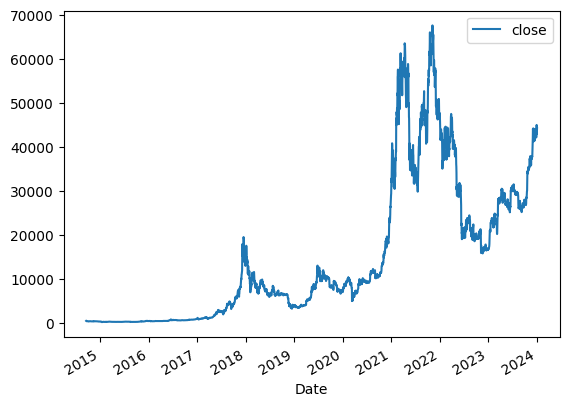

In [9]:
# Download BTC-USD historic data from Yahoo finance
# BTC-USD data starts in 2014
btc_ticker = yf.Ticker("BTC-USD")
btc_df = btc_ticker.history(period="max")

# Tidy up dataframe
btc_df.index = pd.to_datetime(btc_df.index)
btc_df.index = btc_df.index.tz_localize(None)
del btc_df["Dividends"]
del btc_df["Stock Splits"]
btc_df.columns = [c.lower() for c in btc_df.columns]

btc_df.plot.line(y="close",use_index=True)

In [10]:
# Combine btc data with wikipedia data
wiki_df = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True) # Wiki_df starts in 2009
btc_df = btc_df.merge(wiki_df, left_index=True, right_index=True) 

# We are going to predict: 'will the price go up or down tomorrow'
btc_df["tomorrow"] = btc_df["close"].shift(-1)
btc_df['target'] = (btc_df['tomorrow'] > btc_df['close']).astype(int)

In [19]:
## First train a baseline model
# Load Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier
base_model= RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

# Last 200 rows will be used for testing
train = btc_df.iloc[:-200]
test = btc_df.iloc[-200:]

# Define predictors
predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'neg_sentiment']

# Fit the model
base_model.fit(train[predictors], train['target'])


RandomForestClassifier(min_samples_split=50, random_state=1)

In [30]:
## Test base model accuracy
from sklearn.metrics import precision_score

preds = base_model.predict(test[predictors])
preds = pd.Series(preds, index=test.index, name='predictions')
p = precision_score(test['target'], preds) # 50% error accurate with baseline predictions

preds

2023-06-18    1
2023-06-19    0
2023-06-20    0
2023-06-21    1
2023-06-22    0
             ..
2023-12-30    0
2023-12-31    0
2024-01-01    0
2024-01-02    0
2024-01-03    0
Name: predictions, Length: 200, dtype: int32

In [31]:
def predict(train, test, predictors, model):
    '''fits model and produces predictions'''

    # 1) Fit the model on the training dataset
    model.fit(train[predictors], train['target'])

    # 2) Make predictions on the test dataset
    preds = model.predict(test[predictors])

    # 2.1) Convert predictions to pd.Series
    preds = pd.Series(preds, index=test.index, name='predictions')
    
    # 3) Add the predictions to the test dataset
    combined = pd.concat([test['target'], preds], axis=1)

    return combined


# 3) Calculate precicion
    precision_score(test['target'], preds)

def backtest(data, model, predictors, start=1095, step=150):
    '''Backtest throught the dataset to get a more precise '''

    all_predictions = []
    max_i = len(range(start, data.shape[0], step))
    
    # Loop through every step
    for i in range(start, data.shape[0], step):
        
        # 1) Split train and test data
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # 2) Calculate predictions 
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

        print(f'{i}/{max_i} iterations complete')

    # Return a list of all predictioons 
    return pd.concat(all_predictions)

In [37]:
# Load the XGBoost Model
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)

predictions = backtest(btc_df, xgb_model, predictors)

precision_score(predictions['target'], predictions['predictions'])


0.5087853323147441

In [44]:
def compute_rolling(data_df, horizons=[2, 7, 60, 365]): 
    '''Calculates rolling trends in data and adds columns to data_df'''
    
    new_predictors = ['close', 'sentiment', 'neg_sentiment']

    # For each horizon...
    for horizon in horizons: 

        # Calcualte a rolling average dataframe from the input data_df
        # WARNING: Contains data leakage for forward looking datapoints
        rolling_averages = data_df.rolling(horizon, min_periods=1).mean()

        # 1) Closing price ratio
        ratio_column = f'close_ratio_{horizon}'
        data_df[ratio_column] = data_df['close'] / rolling_averages['close']

        # 2) Rolling average edits column
        edit_column = f'edit_{horizon}'
        data_df[edit_column] = rolling_averages['edit_count']

        # 3) Create target trend column with no data leakage
        rolling = data_df.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f'trend_{horizon}'
        data_df[trend_column] = rolling['target']

        new_predictors += [ratio_column, trend_column, edit_column]

    return data_df, new_predictors


btc_df, new_predictors = compute_rolling(btc_df.copy())
btc_df

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0,...,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN,1.000000,5.033333,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0,...,0.0,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000,0.962696,5.050000,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1,...,0.0,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000,0.927789,5.100000,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0,...,0.5,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333,0.970419,5.125000,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1,...,0.5,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000,0.956729,5.146667,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,16013925945,0.300000,-0.097288,0.150000,42265.187500,1,...,0.5,0.985380,0.861905,0.428571,1.065208,9.032222,0.550000,1.464341,1.965845,0.495890
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,16397498810,0.300000,-0.097288,0.150000,44167.332031,1,...,1.0,0.990394,0.685714,0.571429,1.064882,9.024444,0.550000,1.464518,1.963653,0.498630
2024-01-01,42280.234375,44175.437500,42214.976562,44167.332031,18426978443,0.266667,-0.100013,0.150000,44957.968750,1,...,1.0,1.033051,0.538095,0.571429,1.108511,9.016111,0.566667,1.526438,1.961279,0.498630
2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750,39335274536,0.266667,-0.100013,0.150000,42848.175781,0,...,1.0,1.043048,0.419048,0.714286,1.123548,9.006667,0.583333,1.549614,1.958904,0.498630


In [45]:
# Backtest with new predictions
predictions = backtest(btc_df, xgb_model, new_predictors)

In [55]:
# Check accuracy
precision_score(predictions['target'], predictions['predictions'])
predictions['2022-09-01':'2022-09-09']

,target,predictions
2022-09-01,0,1
2022-09-02,0,1
2022-09-03,1,1
2022-09-04,0,1
2022-09-05,0,1
2022-09-06,1,1
2022-09-07,1,1
2022-09-08,1,1
2022-09-09,1,1
